In [1]:
import re
import numpy as np
import pandas as pd

from pathlib import Path

import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold

from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.inspection import permutation_importance

from scipy import stats

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 220)

EXCEL_PATH = Path("Datos finales para análisis IA _proyecto ENTOMOTIVE_.xlsx")
assert EXCEL_PATH.exists(), f"No encuentro el archivo en {EXCEL_PATH}"


In [2]:
xl = pd.ExcelFile(EXCEL_PATH)
xl.sheet_names


['Dietas HERMETIA',
 'Dietas TENEBRIO',
 'Parámetros productivos HERMETIA',
 'Parámetro productivos TENEBRIO',
 'HERMETIA larvas',
 'TENEBRIO larvas',
 'TPC HERMETIA',
 'TPC TENEBRIO']

In [ ]:
def snake(s: str) -> str:
    s = str(s).strip().lower()
    s = s.replace("%", "pct")
    s = re.sub(r"[^\w]+", "_", s, flags=re.UNICODE)
    s = re.sub(r"_+", "_", s).strip("_")
    return s

def normalize_stat(s):
    s = str(s).strip().lower()
    if s in ["media", "mean", "avg"]:
        return "mean"
    if s in ["sd", "std", "desviacion_estandar", "desviación_estándar"]:
        return "sd"
    return snake(s)

def parse_blocks_by_header(df: pd.DataFrame, header_token="Dieta", header_col=0):
    """
    Encuentra índices de filas donde aparece un header (p.ej. 'Dieta' en la 1ª columna),
    típico cuando hay 2 bloques en la misma hoja.
    """
    col = df.iloc[:, header_col].astype(str)
    header_idxs = df.index[col.str.strip().eq(header_token)].tolist()
    return header_idxs

def clean_diet_composition(df_raw: pd.DataFrame) -> pd.DataFrame:
    """
    Limpia hojas tipo 'Dietas HERMETIA' y 'Dietas TENEBRIO' con:
    - fila header: ['Dieta','Tratamiento','Proteína (%)',nan,'Grasa (%)',nan,...]
    - fila stat:   [nan,nan,'Media','SD','Media','SD',...]
    - datos desde la siguiente fila.
    Puede haber 2 bloques (p.ej. TENEBRIO).
    """
    df = df_raw.copy()
    blocks = parse_blocks_by_header(df, header_token="Dieta", header_col=0)
    if not blocks:
        raise ValueError("No encuentro filas de cabecera 'Dieta' en esta hoja")

    out = []
    for bi, h in enumerate(blocks):
        # header fila h, stat fila h+1
        header1 = df.iloc[h].tolist()
        header2 = df.iloc[h+1].tolist()

        # forward-fill header1 para las columnas SD que vienen con NaN
        header1_ff = []
        last = None
        for x in header1:
            if pd.isna(x) or str(x).strip()=="":
                header1_ff.append(last)
            else:
                last = str(x).strip()
                header1_ff.append(last)

        new_cols = []
        for j, (a, b) in enumerate(zip(header1_ff, header2)):
            if j == 0:
                new_cols.append("diet")
                continue
            if j == 1:
                new_cols.append("treatment")
                continue
            nutrient = snake(a)
            stat_ = normalize_stat(b)
            new_cols.append(f"diet_{nutrient}_{stat_}")

        # rango de datos: desde h+2 hasta antes del siguiente bloque
        start = h + 2
        end = blocks[bi+1] if bi+1 < len(blocks) else len(df)
        chunk = df.iloc[start:end].copy()
        chunk.columns = new_cols

        # filtrar filas válidas
        chunk = chunk[chunk["diet"].notna()]
        chunk = chunk[~chunk["diet"].astype(str).str.strip().eq("")]
        chunk = chunk[~chunk["diet"].astype(str).str.strip().eq("Dieta")]
        out.append(chunk)

    comp = pd.concat(out, ignore_index=True)

    # asegurar tipos
    comp["diet"] = comp["diet"].astype(str).str.strip()
    comp["treatment"] = comp["treatment"].astype(str).str.strip()

    # convertir columnas numéricas
    for c in comp.columns:
        if c in ["diet", "treatment"]:
            continue
        comp[c] = pd.to_numeric(comp[c], errors="coerce")

    return comp

def clean_productive(df_raw: pd.DataFrame) -> pd.DataFrame:
    """
    Limpia hojas de parámetros productivos (HERMETIA / TENEBRIO):
    - fila header con nombres completos
    - filas en blanco entre dietas
    """
    df = df_raw.copy()
    # localizar la fila donde la primera col es 'Dieta'
    blocks = parse_blocks_by_header(df, header_token="Dieta", header_col=0)
    if not blocks:
        raise ValueError("No encuentro cabecera 'Dieta' en productivos")
    h = blocks[0]
    header = df.iloc[h].tolist()
    cols = [snake(x) for x in header]
    chunk = df.iloc[h+1:].copy()
    chunk.columns = cols

    chunk = chunk[chunk["dieta"].notna()]
    chunk = chunk[~chunk["dieta"].astype(str).str.strip().isin(["", "Dieta"])]

    # renombrar a nombres estándar
    rename = {
        "dieta": "diet",
        "tratamiento": "treatment",
        "fcr": "fcr",
        "ganancia_de_peso_mg_por_larva": "weight_gain_mg",
        "ganancia_de_peso_mg_media_diaria_por_larva": "weight_gain_daily_mg",
        "reduccion_pct_del_sustrato_reduccion_de_la_masa_de_dieta_suministrada": "substrate_reduction_pct",
        "reduccion_diaria_pct_del_sustrato_reduccion_diaria_de_la_masa_de_dieta_suministrada": "substrate_reduction_daily_pct",
        "peso_total_de_las_larvas_g_al_finalizar_el_periodo_de_alimentacion": "larvae_total_g",
        "peso_total_del_sustrato_g_al_finalizar_el_periodo_de_alimentacion": "substrate_remaining_g",
    }
    chunk = chunk.rename(columns=rename)

    chunk["diet"] = chunk["diet"].astype(str).str.strip()
    chunk["treatment"] = chunk["treatment"].astype(str).str.strip()

    num_cols = [c for c in chunk.columns if c not in ["diet", "treatment"]]
    for c in num_cols:
        chunk[c] = pd.to_numeric(chunk[c], errors="coerce")

    # réplica dentro de dieta (1/2/3)
    chunk["rep"] = chunk.groupby(["diet"]).cumcount() + 1

    return chunk.reset_index(drop=True)

def clean_larvae(df_raw: pd.DataFrame) -> pd.DataFrame:
    """
    Limpia hojas 'HERMETIA larvas' / 'TENEBRIO larvas'
    """
    df = df_raw.copy()
    blocks = parse_blocks_by_header(df, header_token="Dieta", header_col=0)
    if not blocks:
        raise ValueError("No encuentro cabecera 'Dieta' en larvas")
    h = blocks[0]
    header = df.iloc[h].tolist()
    cols = [snake(x) for x in header]
    chunk = df.iloc[h+1:].copy()
    chunk.columns = cols

    chunk = chunk[chunk["dieta"].notna()]
    chunk = chunk[~chunk["dieta"].astype(str).str.strip().isin(["", "Dieta"])]

    rename = {
        "dieta": "diet",
        "tratamiento": "treatment",
        "proteina_pct": "larva_protein_pct",
        "grasa_pct": "larva_fat_pct",
        "quitina_pct": "larva_chitin_pct",
        "cenizas_pct": "larva_ash_pct",
        "carbohidratos_pct": "larva_carb_pct",
    }
    chunk = chunk.rename(columns=rename)

    chunk["diet"] = chunk["diet"].astype(str).str.strip()
    # a veces el tratamiento está vacío en el bloque extra de Tenebrio: lo dejamos como string
    if "treatment" in chunk.columns:
        chunk["treatment"] = chunk["treatment"].astype(str).str.strip()
    else:
        chunk["treatment"] = ""

    num_cols = [c for c in chunk.columns if c not in ["diet", "treatment"]]
    for c in num_cols:
        chunk[c] = pd.to_numeric(chunk[c], errors="coerce")

    chunk["rep"] = chunk.groupby(["diet"]).cumcount() + 1
    return chunk.reset_index(drop=True)

def clean_tpc(df_raw: pd.DataFrame) -> pd.DataFrame:
    """
    Limpia hojas TPC (HERMETIA/TENEBRIO): header real en fila donde col0='Dieta' y luego datos.
    """
    df = df_raw.copy()
    blocks = parse_blocks_by_header(df, header_token="Dieta", header_col=0)
    if not blocks:
        raise ValueError("No encuentro fila 'Dieta' en TPC")
    h = blocks[0]
    header = df.iloc[h].tolist()
    cols = [snake(x) for x in header]
    chunk = df.iloc[h+1:].copy()
    chunk.columns = cols

    chunk = chunk[chunk["dieta"].notna()]
    chunk = chunk[~chunk["dieta"].astype(str).str.strip().isin(["", "Dieta"])]

    # En estas hojas, las columnas vienen como: dieta, tratamiento, media, sd, media, sd
    # Renombramos por posición de forma segura:
    base_cols = list(chunk.columns)
    chunk.columns = ["diet", "treatment", "tpc_diet_mean", "tpc_diet_sd", "tpc_larva_mean", "tpc_larva_sd"]

    chunk["diet"] = chunk["diet"].astype(str).str.strip()
    chunk["treatment"] = chunk["treatment"].astype(str).str.strip()

    print(chunk.columns)

    for c in ["tpc_diet_mean","tpc_diet_sd","tpc_larva_mean","tpc_larva_sd"]:
        chunk[c] = pd.to_numeric(chunk[c], errors="coerce")

    return chunk.reset_index(drop=True)

def parse_diet_name(diet: str):
    """
    Extrae:
    - ingredient (Hoja/Orujo/Quinoa/Posos café/Orujillo/Control/otros)
    - inclusion_pct (número al final si existe)
    """
    d = str(diet).strip()

    # % al final (p.ej. Hoja15, Orujo90, Orujillo50, ... café liof15)
    m = re.search(r"(\d+)\s*$", d)
    pct = int(m.group(1)) if m else 0

    # ingrediente base (texto sin el número final)
    base = re.sub(r"\d+\s*$", "", d).strip()

    # normalización rápida de categorías
    base_low = base.lower()
    if base_low.startswith("control"):
        ingredient = "Control"
        pct = 0
    elif "hoja" in base_low:
        ingredient = "Hoja"
    elif "orujo" in base_low and "orujillo" not in base_low:
        ingredient = "Orujo"
    elif "orujillo" in base_low:
        ingredient = "Orujillo"
    elif "quinoa" in base_low:
        ingredient = "Quinoa"
    elif "posos" in base_low or "café" in base_low or "cafe" in base_low:
        ingredient = "Cafe"
    else:
        ingredient = base

    return ingredient, pct, base

def add_diet_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    tmp = df["diet"].apply(parse_diet_name)
    df["ingredient"] = tmp.apply(lambda x: x[0])
    df["inclusion_pct"] = tmp.apply(lambda x: x[1])
    df["diet_label"] = tmp.apply(lambda x: x[2])

    # ratios útiles (evitan que el modelo “se pierda” con sumas 100%)
    # (si faltan columnas, simplemente no las crea)
    if "diet_proteina_pct_mean" in df.columns and "diet_carbohidratos_pct_mean" in df.columns:
        df["ratio_protein_carb"] = df["diet_proteina_pct_mean"] / (df["diet_carbohidratos_pct_mean"] + 1e-9)
    if "diet_proteina_pct_mean" in df.columns and "diet_grasa_pct_mean" in df.columns:
        df["ratio_protein_fat"] = df["diet_proteina_pct_mean"] / (df["diet_grasa_pct_mean"] + 1e-9)
    if "diet_fibra_pct_mean" in df.columns and "diet_grasa_pct_mean" in df.columns:
        df["ratio_fiber_fat"] = df["diet_fibra_pct_mean"] / (df["diet_grasa_pct_mean"] + 1e-9)

    return df


In [18]:
raw = {name: xl.parse(name) for name in xl.sheet_names}

diet_H = clean_diet_composition(raw["Dietas HERMETIA"])
diet_T = clean_diet_composition(raw["Dietas TENEBRIO"])

prod_H = clean_productive(raw["Parámetros productivos HERMETIA"])
prod_T = clean_productive(raw["Parámetro productivos TENEBRIO"])

larv_H = clean_larvae(raw["HERMETIA larvas"])
larv_T = clean_larvae(raw["TENEBRIO larvas"])

tpc_H = clean_tpc(raw["TPC HERMETIA"])
tpc_T = clean_tpc(raw["TPC TENEBRIO"])

diet_H.head(), diet_T.head(), prod_H.head(), larv_H.head(), tpc_H.head()


TPC columnas originales: ['dieta', 'tratamiento', 'media', 'sd', 'media', 'sd']
Index(['diet', 'treatment', 'tpc_diet_mean', 'tpc_diet_sd', 'tpc_larva_mean', 'tpc_larva_sd'], dtype='object')
TPC columnas originales: ['dieta', 'tratamiento', 'media', 'sd', 'media', 'sd']
Index(['diet', 'treatment', 'tpc_diet_mean', 'tpc_diet_sd', 'tpc_larva_mean', 'tpc_larva_sd'], dtype='object')


(      diet treatment  diet_proteína_pct_mean  diet_proteína_pct_sd  diet_grasa_pct_mean  diet_grasa_pct_sd  diet_fibra_pct_mean  diet_fibra_pct_sd  diet_cenizas_pct_mean  diet_cenizas_pct_sd  \
 0  Control         0               18.175156              0.435439             2.766018           0.029604             2.513074           0.093525              22.034336             0.096530   
 1   Hoja15         1               16.838123              0.258047             2.650274           0.023624             3.702291           0.181163              19.294028             0.081509   
 2   Hoja30         2               15.137502              0.238090             2.622729           0.113278             5.223646           0.117353              16.872466             0.190969   
 3   Hoja50         3               13.511368              0.191933             2.931321           0.041274             7.773009           0.197489              14.292793             0.163029   
 4  Orujo30         4    

In [19]:
def build_master(species: str,
                 diet_df: pd.DataFrame,
                 prod_df: pd.DataFrame,
                 larv_df: pd.DataFrame,
                 tpc_df: pd.DataFrame | None) -> pd.DataFrame:
    """
    Crea dataset por réplica:
    (diet,treatment,rep) + composición dieta + productivos + composición larva + TPC (si existe).
    """
    df_prod = prod_df.copy()
    df_larv = larv_df.copy()

    # Para TENEBRIO: algunos tratamientos vienen vacíos en larvas (bloque extra),
    # y los "Control Seco/Agar/Humedad" no están en Dietas con tratamiento A.1/A.2/A.3.
    # Creamos claves de merge base: (diet_base, treatment_base)
    df_prod["diet_base"] = df_prod["diet"]
    df_prod["treatment_base"] = df_prod["treatment"]

    df_larv["diet_base"] = df_larv["diet"]
    df_larv["treatment_base"] = df_larv["treatment"]

    if species.lower() == "tenebrio":
        # Variantes de control con agua → misma composición que 'Control' tratamiento 'A' (bloque 2 dietas)
        control_variants = ["Control Seco", "Control Agar", "Control Humedad superf"]
        map_treat = {
            "Control Seco": "A",
            "Control Agar": "A",
            "Control Humedad superf": "A",
        }
        df_prod.loc[df_prod["diet"].isin(control_variants), "diet_base"] = "Control"
        df_prod.loc[df_prod["diet"].isin(control_variants), "treatment_base"] = df_prod.loc[df_prod["diet"].isin(control_variants), "diet"].map(map_treat).fillna("A")

        df_larv.loc[df_larv["diet"].isin(control_variants), "diet_base"] = "Control"
        df_larv.loc[df_larv["diet"].isin(control_variants), "treatment_base"] = "A"

        # Bloque café/orujillo: si treatment falta en larvas, lo derivamos
        treat_from_diet = {
            "Posos café liof15": "B",
            "Posos café horno15": "C",
            "Orujillo15": "D",
            "Orujillo30": "E",
            "Orujillo50": "F",
        }
        df_larv.loc[df_larv["treatment_base"].isin(["", "nan", "NaN", "None"]), "treatment_base"] = (
            df_larv["diet"].map(treat_from_diet).fillna(df_larv["treatment_base"])
        )
        df_prod.loc[df_prod["diet"].isin(treat_from_diet.keys()), "treatment_base"] = df_prod["diet"].map(treat_from_diet).fillna(df_prod["treatment_base"])

        # Para el bloque principal (0..10) mantenemos diet_base = diet
        # Para la dieta 'Control' principal: treatment_base ya es "0", no "A" → son dos controles distintos en análisis dietas.
        # Esto está bien: el control "A" es el del bloque café/orujillo, y el control "0" es el del estudio principal.

    # Merge productivo + larva por (diet, rep). (treatment puede ser irregular en Tenebrio extra)
    merged = df_prod.merge(
        df_larv.drop(columns=["treatment"], errors="ignore"),
        on=["diet", "rep"],
        how="left",
        suffixes=("", "_larv")
    )

    # Merge composición dieta por claves base (diet_base, treatment_base)
    merged = merged.merge(
        diet_df.rename(columns={"diet":"diet_base","treatment":"treatment_base"}),
        on=["diet_base", "treatment_base"],
        how="left"
    )

    # Merge TPC si existe (solo para dietas principales típicamente)
    if tpc_df is not None:
        merged = merged.merge(
            tpc_df.rename(columns={"diet":"diet_base","treatment":"treatment_base"}),
            on=["diet_base", "treatment_base"],
            how="left"
        )

    merged["species"] = species
    return merged

master_H = build_master("Hermetia", diet_H, prod_H, larv_H, tpc_H)
master_T = build_master("Tenebrio", diet_T, prod_T, larv_T, tpc_T)

master_H.shape, master_T.shape, master_H.head(3), master_T.head(3)


((33, 34),
 (57, 34),
       diet treatment       fcr  weight_gain_mg  weight_gain_daily_mg  reducción_pct_del_sustrato_reducción_de_la_masa_de_dieta_suministrada  \
 0  Control         0  1.767204          138.77             11.564167                                          57.673863                       
 1  Control         0  1.611845          168.14             14.011667                                          68.672394                       
 2  Control         0  1.469797          163.20             13.600000                                          69.976968                       
 
    reducción_diaria_pct_del_sustrato_reducción_diaria_de_la_masa_de_dieta_suministrada  peso_total_de_las_larvas_g_al_finalizar_el_periodo_de_alimentación  \
 0                                           4.806155                                                                               1544.0                    
 1                                           5.722699                             

In [23]:
KEY_TARGETS = [
    "fcr",
    "weight_gain_mg",
    "substrate_reduction_pct",
    "larva_protein_pct",
    "larva_fat_pct",
    "tpc_larva_mean",
]

def summarize_by_diet(df: pd.DataFrame, targets=KEY_TARGETS):
    cols = [c for c in targets if c in df.columns]
    out = df.groupby(["diet","diet_base"], dropna=False)[cols].agg(["mean","std","count"])
    return out

sum_H = summarize_by_diet(master_H)
sum_T = summarize_by_diet(master_T)

sum_H.head(10)


fcr                 weight_gain_mg                  larva_protein_pct                 larva_fat_pct                 tpc_larva_mean           
                        mean       std count           mean        std count              mean       std count          mean       std count           mean  std count
diet     diet_base                                                                                                                                                    
Control  Control    1.616282  0.148753     3     156.703333  15.725910     3         31.936173  0.390720     3     11.498079  5.203921     3       0.432843  0.0     3
Hoja15   Hoja15     1.607828  0.291169     3     140.980000  25.256540     3         31.417118  1.302954     3      8.225027  1.528512     3       0.358376  0.0     3
Hoja30   Hoja30     1.756820  0.106978     3      77.596667   1.722392     3         24.417325  0.898261     3     21.223611  2.955587     3       0.442705  0.0     3
Hoja50   Hoja50     2.317768  0.472500     2      43.186667   6.574058     3         23.370496  0.686536     3     14.909885  2.274037     3       0.311790  0.0     3
Orujo30  Orujo30    1.855255  0.455530     3     119.206667  15.232631     3         30.321931  1.455310     3     10.156761  4.221184     3       0.351143  0.0     3
Orujo50  Orujo50    1.733239  0.388331     3     119.133333   9.427923     3         32.147393  0.957034     3     11.032152  2.352739     3       0.316360  0.0     3
Orujo70  Orujo70    1.907479  0.034918     3      91.723333  19.229026     3         27.401729  0.665612     3     16.292617  1.868591     3       0.393268  0.0     3
Orujo90  Orujo90    2.270433  0.164208     2      51.323333   8.804523     3         26.546877  2.487327     3     20.862635  3.149024     3       0.593574  0.0     3
Quinoa15 Quinoa15   1.779622  0.101186     3     134.670000  31.682075     3         30.767016  1.315511     3      8.194761  2.135972     3       0.290828  0.0     3
Quinoa30 Quinoa30   1.543216  0.012914     3     140.750000   4.818848     3         29.984111  0.767391     3      8.705478  2.753846     3       0.339831  0.0     3

In [24]:
def ranking_table(df: pd.DataFrame, target: str, higher_is_better=True):
    assert target in df.columns, f"No existe {target}"
    g = df.groupby(["diet"], dropna=False)[target].agg(["mean","std","count"]).reset_index()
    g = g.sort_values("mean", ascending=not higher_is_better)
    return g

def percent_change_vs_control(df: pd.DataFrame, target: str, control_name="Control"):
    g = df.groupby(["diet"], dropna=False)[target].mean()
    if control_name not in g.index:
        return None
    base = g.loc[control_name]
    out = (g - base) / (base + 1e-9) * 100
    return out.sort_values(ascending=False)

for t in ["weight_gain_mg","fcr","larva_protein_pct","tpc_larva_mean"]:
    if t in master_H.columns:
        print("\nHERMETIA —", t)
        display(ranking_table(master_H, t, higher_is_better=(t!="fcr")).head(10))
        pc = percent_change_vs_control(master_H, t)
        if pc is not None:
            print("Δ% vs Control (media):")
            display(pc.to_frame("pct_change").head(10))

for t in ["weight_gain_mg","fcr","larva_protein_pct","tpc_larva_mean"]:
    if t in master_T.columns:
        print("\nTENEBRIO —", t)
        display(ranking_table(master_T, t, higher_is_better=(t!="fcr")).head(12))
        pc = percent_change_vs_control(master_T, t)
        if pc is not None:
            print("Δ% vs Control (media):")
            display(pc.to_frame("pct_change").head(12))



HERMETIA — weight_gain_mg


,diet,mean,std,count
0,Control,156.703333,15.725910,3
1,Hoja15,140.980000,25.256540,3
9,Quinoa30,140.750000,4.818848,3
8,Quinoa15,134.670000,31.682075,3
4,Orujo30,119.206667,15.232631,3
5,Orujo50,119.133333,9.427923,3
10,Quinoa50,111.716667,14.570550,3
6,Orujo70,91.723333,19.229026,3
2,Hoja30,77.596667,1.722392,3
7,Orujo90,51.323333,8.804523,3


Δ% vs Control (media):


,pct_change
diet,
Control,0.000000
Hoja15,-10.033822
Quinoa30,-10.180596
Quinoa15,-14.060539
Orujo30,-23.928442
Orujo50,-23.975240
Quinoa50,-28.708175
Orujo70,-41.466891
Hoja30,-50.481802



HERMETIA — fcr


,diet,mean,std,count
9,Quinoa30,1.543216,0.012914,3
1,Hoja15,1.607828,0.291169,3
0,Control,1.616282,0.148753,3
5,Orujo50,1.733239,0.388331,3
2,Hoja30,1.756820,0.106978,3
8,Quinoa15,1.779622,0.101186,3
4,Orujo30,1.855255,0.455530,3
6,Orujo70,1.907479,0.034918,3
10,Quinoa50,2.028251,0.176666,3
7,Orujo90,2.270433,0.164208,2


Δ% vs Control (media):


,pct_change
diet,
Hoja50,43.401230
Orujo90,40.472596
Quinoa50,25.488701
Orujo70,18.016507
Orujo30,14.785333
Quinoa15,10.105939
Hoja30,8.695139
Orujo50,7.236178
Control,0.000000



HERMETIA — larva_protein_pct


,diet,mean,std,count
5,Orujo50,32.147393,0.957034,3
0,Control,31.936173,0.390720,3
1,Hoja15,31.417118,1.302954,3
8,Quinoa15,30.767016,1.315511,3
4,Orujo30,30.321931,1.455310,3
9,Quinoa30,29.984111,0.767391,3
10,Quinoa50,29.829991,1.392704,3
6,Orujo70,27.401729,0.665612,3
7,Orujo90,26.546877,2.487327,3
2,Hoja30,24.417325,0.898261,3


Δ% vs Control (media):


,pct_change
diet,
Orujo50,0.661383
Control,0.000000
Hoja15,-1.625289
Quinoa15,-3.660915
Orujo30,-5.054586
Quinoa30,-6.112385
Quinoa50,-6.594973
Orujo70,-14.198455
Orujo90,-16.875207



HERMETIA — tpc_larva_mean


,diet,mean,std,count
7,Orujo90,0.593574,0.0,3
2,Hoja30,0.442705,0.0,3
0,Control,0.432843,0.0,3
6,Orujo70,0.393268,0.0,3
10,Quinoa50,0.384035,0.0,3
1,Hoja15,0.358376,0.0,3
4,Orujo30,0.351143,0.0,3
9,Quinoa30,0.339831,0.0,3
5,Orujo50,0.316360,0.0,3
3,Hoja50,0.311790,0.0,3


Δ% vs Control (media):


,pct_change
diet,
Orujo90,37.133940
Hoja30,2.278422
Control,0.000000
Orujo70,-9.143075
Quinoa50,-11.276027
Hoja15,-17.204054
Orujo30,-18.875086
Quinoa30,-21.488691
Orujo50,-26.911216



TENEBRIO — weight_gain_mg


,diet,mean,std,count
1,Control Agar,103.933333,6.916888,3
7,Orujillo15,94.866667,2.250185,3
8,Orujillo30,87.333333,4.315476,3
9,Orujillo50,71.033333,3.911948,3
2,Control Humedad superf,62.900000,1.513275,3
14,Posos café horno15,62.450667,3.951094,3
3,Control Seco,53.333333,3.233162,3
0,Control,44.750000,4.596194,2
15,Posos café liof15,44.266667,1.386843,3
10,Orujo30,43.250000,4.313351,2


Δ% vs Control (media):


,pct_change
diet,
Control Agar,132.253259
Orujillo15,111.992551
Orujillo30,95.158287
Orujillo50,58.733706
Control Humedad superf,40.558659
Posos café horno15,39.554562
Control Seco,19.180633
Control,0.000000
Posos café liof15,-1.080074



TENEBRIO — fcr


,diet,mean,std,count
14,Posos café horno15,1.303954,0.000000,3
15,Posos café liof15,1.366667,0.152753,3
8,Orujillo30,1.400000,0.000000,3
9,Orujillo50,1.400000,0.173205,3
13,Orujo90,1.403504,0.443734,3
7,Orujillo15,1.500000,0.000000,3
1,Control Agar,1.566667,0.057735,3
18,Quinoa50,2.283250,0.161718,3
6,Hoja50,2.288884,0.192006,3
17,Quinoa30,2.413962,0.101272,3


Δ% vs Control (media):


,pct_change
diet,
Control Seco,5.126346
Orujo30,5.082006
Control,0.000000
Quinoa15,-2.286820
Hoja15,-5.692535
Orujo50,-5.983385
Control Humedad superf,-10.229187
Orujo70,-11.089477
Hoja30,-14.405169



TENEBRIO — larva_protein_pct


,diet,mean,std,count
15,Posos café liof15,50.916000,3.783021,2
16,Quinoa15,48.345332,1.854879,3
11,Orujo50,47.120193,0.503146,3
18,Quinoa50,46.719090,0.469803,3
17,Quinoa30,46.574596,1.121780,3
10,Orujo30,46.512956,2.140794,3
4,Hoja15,45.721612,2.496341,3
5,Hoja30,43.800517,1.450975,3
6,Hoja50,43.603417,0.938935,3
0,Control,43.284851,0.538600,3


Δ% vs Control (media):


,pct_change
diet,
Posos café liof15,17.630069
Quinoa15,11.691114
Orujo50,8.860704
Quinoa50,7.934043
Quinoa30,7.600223
Orujo30,7.457817
Hoja15,5.629593
Hoja30,1.191332
Hoja50,0.735977



TENEBRIO — tpc_larva_mean


,diet,mean,std,count
6,Hoja50,0.450093,0.0,3
16,Quinoa15,0.410193,0.0,3
5,Hoja30,0.399321,0.0,3
13,Orujo90,0.382553,0.0,3
17,Quinoa30,0.381096,0.0,3
11,Orujo50,0.372296,0.0,3
18,Quinoa50,0.369375,0.0,3
4,Hoja15,0.363926,0.0,3
12,Orujo70,0.356132,0.0,3
0,Control,0.321229,0.0,3


Δ% vs Control (media):


,pct_change
diet,
Hoja50,40.115790
Quinoa15,27.694589
Hoja30,24.310326
Orujo90,19.090402
Quinoa30,18.636712
Orujo50,15.897308
Quinoa50,14.987893
Hoja15,13.291486
Orujo70,10.865179


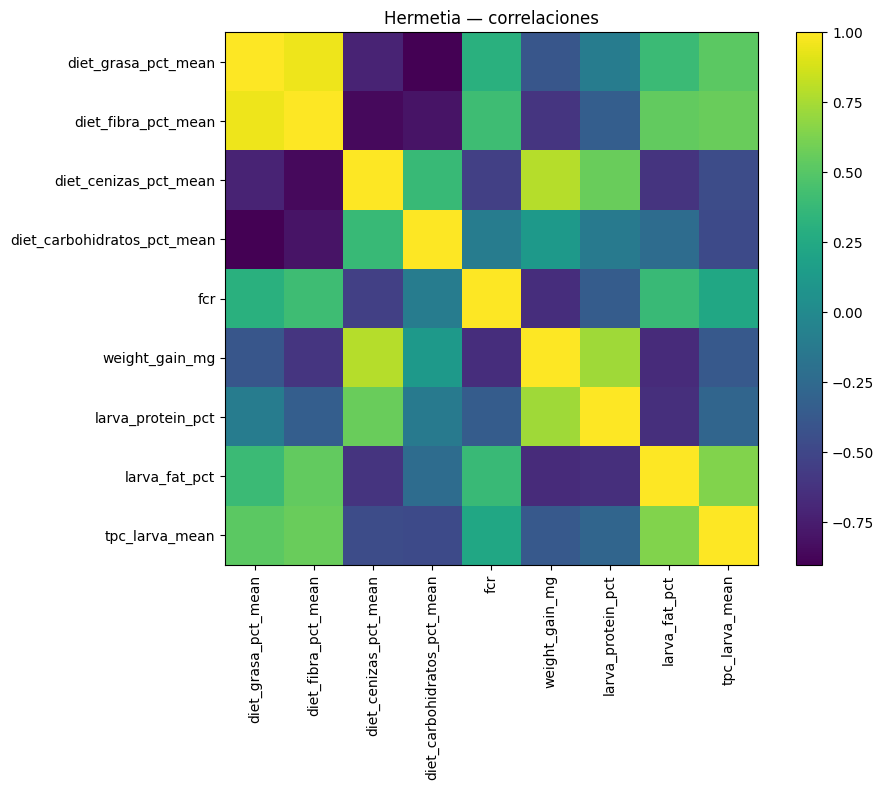

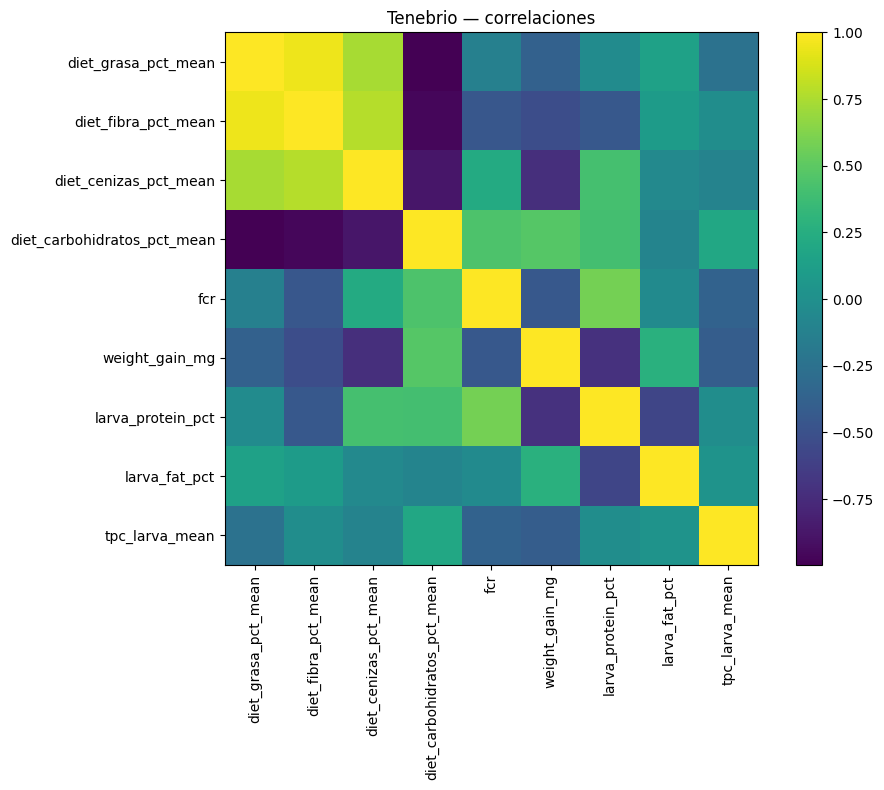

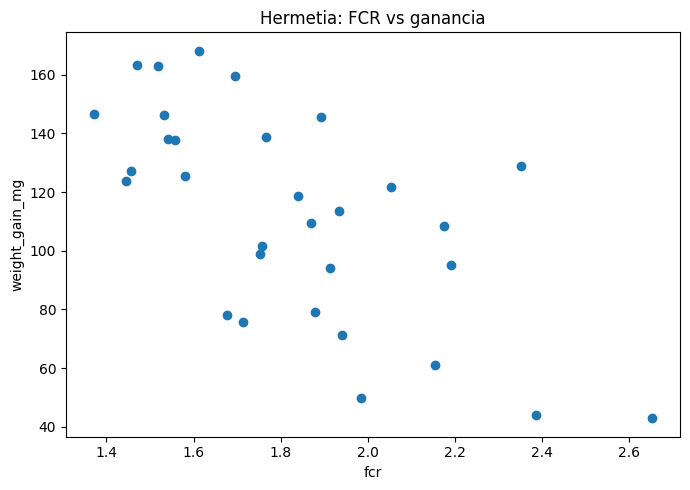

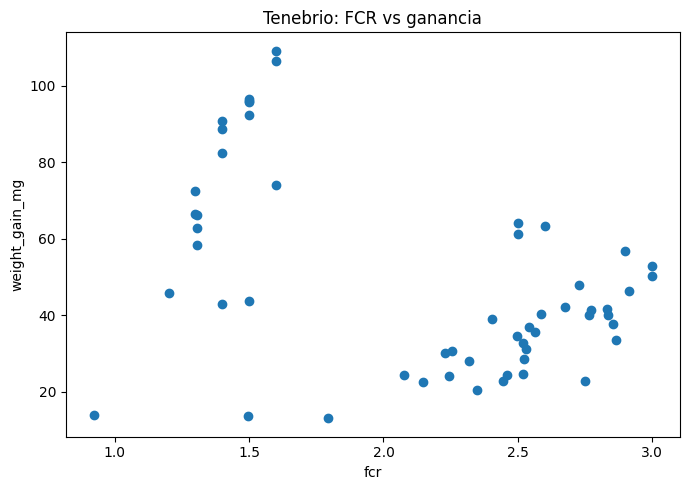

In [25]:
def corr_heatmap(df: pd.DataFrame, cols, title=""):
    X = df[cols].copy()
    corr = X.corr(numeric_only=True)
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(corr.values)
    ax.set_xticks(range(len(cols)))
    ax.set_yticks(range(len(cols)))
    ax.set_xticklabels(cols, rotation=90)
    ax.set_yticklabels(cols)
    ax.set_title(title)
    fig.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()

eda_cols_H = [c for c in [
    "diet_proteina_pct_mean","diet_grasa_pct_mean","diet_fibra_pct_mean","diet_cenizas_pct_mean","diet_carbohidratos_pct_mean",
    "fcr","weight_gain_mg","larva_protein_pct","larva_fat_pct","tpc_larva_mean"
] if c in master_H.columns]

eda_cols_T = [c for c in [
    "diet_proteina_pct_mean","diet_grasa_pct_mean","diet_fibra_pct_mean","diet_cenizas_pct_mean","diet_carbohidratos_pct_mean",
    "fcr","weight_gain_mg","larva_protein_pct","larva_fat_pct","tpc_larva_mean"
] if c in master_T.columns]

corr_heatmap(master_H, eda_cols_H, "Hermetia — correlaciones")
corr_heatmap(master_T, eda_cols_T, "Tenebrio — correlaciones")

# Scatter clave: FCR vs ganancia
def scatter(df, x, y, title=""):
    d = df.dropna(subset=[x,y]).copy()
    fig, ax = plt.subplots(figsize=(7,5))
    ax.scatter(d[x], d[y])
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

if "fcr" in master_H.columns and "weight_gain_mg" in master_H.columns:
    scatter(master_H, "fcr", "weight_gain_mg", "Hermetia: FCR vs ganancia")

if "fcr" in master_T.columns and "weight_gain_mg" in master_T.columns:
    scatter(master_T, "fcr", "weight_gain_mg", "Tenebrio: FCR vs ganancia")


In [26]:
def quick_group_tests(df: pd.DataFrame, target: str, group="diet"):
    d = df[[group, target]].dropna()
    if d[group].nunique() < 2:
        return None

    groups = [g[target].values for _, g in d.groupby(group)]
    # ANOVA (asume normalidad aproximada)
    anova = stats.f_oneway(*groups)

    # Kruskal (no paramétrico)
    kruskal = stats.kruskal(*groups)

    return {
        "anova_F": anova.statistic, "anova_p": anova.pvalue,
        "kruskal_H": kruskal.statistic, "kruskal_p": kruskal.pvalue,
        "n_groups": d[group].nunique(),
        "n_total": len(d)
    }

for t in ["fcr","weight_gain_mg","larva_protein_pct","tpc_larva_mean"]:
    if t in master_H.columns:
        print("Hermetia —", t, quick_group_tests(master_H, t))
    if t in master_T.columns:
        print("Tenebrio —", t, quick_group_tests(master_T, t))

# Tukey HSD (opcional) si tienes statsmodels instalado
try:
    from statsmodels.stats.multicomp import pairwise_tukeyhsd

    def tukey(df, target, group="diet"):
        d = df[[group,target]].dropna()
        res = pairwise_tukeyhsd(endog=d[target], groups=d[group], alpha=0.05)
        return pd.DataFrame(data=res.summary().data[1:], columns=res.summary().data[0])

    if "weight_gain_mg" in master_H.columns:
        print("\nTukey Hermetia — weight_gain_mg")
        display(tukey(master_H, "weight_gain_mg").head(20))

except Exception as e:
    print("Tukey no disponible (statsmodels no instalado o error):", e)


Hermetia — fcr {'anova_F': np.float64(2.4590019919567125), 'anova_p': np.float64(0.041611357357684786), 'kruskal_H': np.float64(15.808467741935488), 'kruskal_p': np.float64(0.10524807217113782), 'n_groups': 11, 'n_total': 31}
Tenebrio — fcr {'anova_F': np.float64(40.985751981108265), 'anova_p': np.float64(1.9593790488382812e-19), 'kruskal_H': np.float64(51.86504408026397), 'kruskal_p': np.float64(3.9243041706875146e-05), 'n_groups': 19, 'n_total': 57}
Hermetia — weight_gain_mg {'anova_F': np.float64(15.842946635531916), 'anova_p': np.float64(7.52996031064248e-08), 'kruskal_H': np.float64(26.96613190730838), 'kruskal_p': np.float64(0.0026366623312275737), 'n_groups': 11, 'n_total': 33}
Tenebrio — weight_gain_mg {'anova_F': np.float64(156.63513546871), 'anova_p': np.float64(9.191067349177553e-29), 'kruskal_H': np.float64(52.89427829286774), 'kruskal_p': np.float64(2.7243093120591983e-05), 'n_groups': 19, 'n_total': 55}
Hermetia — larva_protein_pct {'anova_F': np.float64(17.82330023461470

c:\Users\maria\Downloads\Jose_lenovo\TFG\surrogate_models\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\maria\Downloads\Jose_lenovo\TFG\surrogate_models\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  res = hypotest_fun_out(*samples, **kwds)


In [30]:
def loodo_cv_regression(
    df: pd.DataFrame,
    target: str,
    numeric_features: list[str],
    categorical_features: list[str],
    models: dict,
    group_col: str = "diet_base",
    min_rows: int = 12
):
    """
    CV Leave-One-Group-Out manual (deja fuera una dieta completa).
    Evita fuga: si hay 3 réplicas por dieta, se quedan juntas en test.
    """
    data = df.copy()
    data = data.dropna(subset=[target])
    if len(data) < min_rows or data[group_col].nunique() < 4:
        print(f"[WARN] Pocos datos para modelar {target}: n={len(data)}, grupos={data[group_col].nunique()}")
        return None

    X = data[numeric_features + categorical_features].copy()
    y = data[target].copy()
    groups = data[group_col].astype(str).copy()

    # Preprocesado
    num_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ])
    cat_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ])

    pre = ColumnTransformer(
        transformers=[
            ("num", num_pipe, numeric_features),
            ("cat", cat_pipe, categorical_features),
        ],
        remainder="drop"
    )

    # splits LOODO
    unique_groups = groups.unique()
    rows = []
    preds_store = {}

    for model_name, model in models.items():
        y_true_all, y_pred_all = [], []
        fold_info = []

        for g in unique_groups:
            test_idx = (groups == g).values
            train_idx = ~test_idx

            X_train, y_train = X.loc[train_idx], y.loc[train_idx]
            X_test, y_test = X.loc[test_idx], y.loc[test_idx]

            pipe = Pipeline(steps=[("pre", pre), ("model", model)])
            pipe.fit(X_train, y_train)
            y_pred = pipe.predict(X_test)

            y_true_all.extend(y_test.tolist())
            y_pred_all.extend(np.array(y_pred).ravel().tolist())

            fold_info.append({
                "held_out_group": g,
                "n_test": int(test_idx.sum()),
                "mae": float(mean_absolute_error(y_test, y_pred)),
                "rmse": float(mean_squared_error(y_test, y_pred)),
            })

        mae = mean_absolute_error(y_true_all, y_pred_all)
        rmse = mean_squared_error(y_true_all, y_pred_all)
        r2 = r2_score(y_true_all, y_pred_all)

        rows.append({
            "model": model_name,
            "target": target,
            "n": len(data),
            "n_groups": len(unique_groups),
            "MAE": mae,
            "RMSE": rmse,
            "R2": r2,
        })
        preds_store[model_name] = {"y_true": np.array(y_true_all), "y_pred": np.array(y_pred_all), "folds": pd.DataFrame(fold_info)}

    res = pd.DataFrame(rows).sort_values("MAE")
    return res, preds_store

# Modelos (rápidos, razonables para poco n)
MODELS = {
    "Linear": LinearRegression(),
    "RidgeCV": RidgeCV(alphas=np.logspace(-3, 3, 25)),
    "LassoCV": LassoCV(alphas=None, cv=5, max_iter=20000),
    "PLS(2)": PLSRegression(n_components=2),
    "RF": RandomForestRegressor(n_estimators=400, random_state=0)
}


In [31]:
# Features numéricas dieta (medias) + ratios + TPC dieta (si existe)
def feature_sets(df: pd.DataFrame):
    num = []
    for c in [
        "diet_proteina_pct_mean","diet_grasa_pct_mean","diet_fibra_pct_mean","diet_cenizas_pct_mean","diet_carbohidratos_pct_mean",
        "ratio_protein_carb","ratio_protein_fat","ratio_fiber_fat",
        "tpc_diet_mean"
    ]:
        if c in df.columns:
            num.append(c)

    cat = []
    for c in ["ingredient","diet_label"]:
        if c in df.columns:
            cat.append(c)

    return num, cat

targets_to_try = ["fcr","weight_gain_mg","larva_protein_pct","larva_fat_pct","tpc_larva_mean"]

def run_all(df: pd.DataFrame, species: str):
    num, cat = feature_sets(df)
    print("\n" + "#"*90)
    print(species, "— features num:", num)
    print(species, "— features cat:", cat)

    all_res = []
    all_preds = {}

    for t in targets_to_try:
        if t not in df.columns:
            continue
        out = loodo_cv_regression(
            df=df,
            target=t,
            numeric_features=num,
            categorical_features=cat,
            models=MODELS,
            group_col="diet_base"
        )
        if out is None:
            continue
        res, preds = out
        display(res)
        all_res.append(res)
        all_preds[t] = preds

    if all_res:
        big = pd.concat(all_res, ignore_index=True).sort_values(["target","MAE"])
        return big, all_preds
    return None, None

res_H, preds_H = run_all(master_H, "Hermetia")
res_T, preds_T = run_all(master_T, "Tenebrio")

res_H, res_T



##########################################################################################
Hermetia — features num: ['diet_grasa_pct_mean', 'diet_fibra_pct_mean', 'diet_cenizas_pct_mean', 'diet_carbohidratos_pct_mean', 'tpc_diet_mean']
Hermetia — features cat: []


c:\Users\maria\Downloads\Jose_lenovo\TFG\surrogate_models\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1641: FutureWarning: 'alphas=None' is deprecated and will be removed in 1.9, at which point the default value will be set to 100. Set 'alphas=100' to silence this warning.
  warnings.warn(
c:\Users\maria\Downloads\Jose_lenovo\TFG\surrogate_models\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1641: FutureWarning: 'alphas=None' is deprecated and will be removed in 1.9, at which point the default value will be set to 100. Set 'alphas=100' to silence this warning.
  warnings.warn(
c:\Users\maria\Downloads\Jose_lenovo\TFG\surrogate_models\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1641: FutureWarning: 'alphas=None' is deprecated and will be removed in 1.9, at which point the default value will be set to 100. Set 'alphas=100' to silence this warning.
  warnings.warn(
c:\Users\maria\Downloads\Jose_lenovo\TFG\surrogate_mode

,model,target,n,n_groups,MAE,RMSE,R2
2,LassoCV,fcr,31,11,0.237434,0.091178,0.016623
1,RidgeCV,fcr,31,11,0.241031,0.090892,0.019707
3,PLS(2),fcr,31,11,0.243156,0.088840,0.041844
4,RF,fcr,31,11,0.272343,0.108083,-0.165706
0,Linear,fcr,31,11,0.387206,0.205085,-1.211896


c:\Users\maria\Downloads\Jose_lenovo\TFG\surrogate_models\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1641: FutureWarning: 'alphas=None' is deprecated and will be removed in 1.9, at which point the default value will be set to 100. Set 'alphas=100' to silence this warning.
  warnings.warn(
c:\Users\maria\Downloads\Jose_lenovo\TFG\surrogate_models\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1641: FutureWarning: 'alphas=None' is deprecated and will be removed in 1.9, at which point the default value will be set to 100. Set 'alphas=100' to silence this warning.
  warnings.warn(
c:\Users\maria\Downloads\Jose_lenovo\TFG\surrogate_models\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1641: FutureWarning: 'alphas=None' is deprecated and will be removed in 1.9, at which point the default value will be set to 100. Set 'alphas=100' to silence this warning.
  warnings.warn(
c:\Users\maria\Downloads\Jose_lenovo\TFG\surrogate_mode

,model,target,n,n_groups,MAE,RMSE,R2
3,PLS(2),weight_gain_mg,33,11,13.915081,329.816725,0.774215
1,RidgeCV,weight_gain_mg,33,11,17.809584,473.219222,0.676046
2,LassoCV,weight_gain_mg,33,11,18.089182,483.808286,0.668797
0,Linear,weight_gain_mg,33,11,21.449724,665.989915,0.544080
4,RF,weight_gain_mg,33,11,23.939425,770.245134,0.472709


c:\Users\maria\Downloads\Jose_lenovo\TFG\surrogate_models\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1641: FutureWarning: 'alphas=None' is deprecated and will be removed in 1.9, at which point the default value will be set to 100. Set 'alphas=100' to silence this warning.
  warnings.warn(
c:\Users\maria\Downloads\Jose_lenovo\TFG\surrogate_models\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1641: FutureWarning: 'alphas=None' is deprecated and will be removed in 1.9, at which point the default value will be set to 100. Set 'alphas=100' to silence this warning.
  warnings.warn(
c:\Users\maria\Downloads\Jose_lenovo\TFG\surrogate_models\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1641: FutureWarning: 'alphas=None' is deprecated and will be removed in 1.9, at which point the default value will be set to 100. Set 'alphas=100' to silence this warning.
  warnings.warn(
c:\Users\maria\Downloads\Jose_lenovo\TFG\surrogate_mode

,model,target,n,n_groups,MAE,RMSE,R2
3,PLS(2),larva_protein_pct,33,11,1.648183,3.773241,0.598831
4,RF,larva_protein_pct,33,11,1.688766,3.976986,0.577169
2,LassoCV,larva_protein_pct,33,11,1.715340,4.385270,0.533760
1,RidgeCV,larva_protein_pct,33,11,1.829602,4.531960,0.518164
0,Linear,larva_protein_pct,33,11,2.049619,5.613193,0.403208


c:\Users\maria\Downloads\Jose_lenovo\TFG\surrogate_models\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1641: FutureWarning: 'alphas=None' is deprecated and will be removed in 1.9, at which point the default value will be set to 100. Set 'alphas=100' to silence this warning.
  warnings.warn(
c:\Users\maria\Downloads\Jose_lenovo\TFG\surrogate_models\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1641: FutureWarning: 'alphas=None' is deprecated and will be removed in 1.9, at which point the default value will be set to 100. Set 'alphas=100' to silence this warning.
  warnings.warn(
c:\Users\maria\Downloads\Jose_lenovo\TFG\surrogate_models\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1641: FutureWarning: 'alphas=None' is deprecated and will be removed in 1.9, at which point the default value will be set to 100. Set 'alphas=100' to silence this warning.
  warnings.warn(
c:\Users\maria\Downloads\Jose_lenovo\TFG\surrogate_mode

,model,target,n,n_groups,MAE,RMSE,R2
4,RF,larva_fat_pct,33,11,3.853194,24.455285,0.079886
3,PLS(2),larva_fat_pct,33,11,4.167749,27.891856,-0.049412
1,RidgeCV,larva_fat_pct,33,11,4.219965,27.329918,-0.028270
2,LassoCV,larva_fat_pct,33,11,4.272802,26.784802,-0.007760
0,Linear,larva_fat_pct,33,11,5.081080,38.640704,-0.453831


c:\Users\maria\Downloads\Jose_lenovo\TFG\surrogate_models\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1641: FutureWarning: 'alphas=None' is deprecated and will be removed in 1.9, at which point the default value will be set to 100. Set 'alphas=100' to silence this warning.
  warnings.warn(
c:\Users\maria\Downloads\Jose_lenovo\TFG\surrogate_models\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1641: FutureWarning: 'alphas=None' is deprecated and will be removed in 1.9, at which point the default value will be set to 100. Set 'alphas=100' to silence this warning.
  warnings.warn(
c:\Users\maria\Downloads\Jose_lenovo\TFG\surrogate_models\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1641: FutureWarning: 'alphas=None' is deprecated and will be removed in 1.9, at which point the default value will be set to 100. Set 'alphas=100' to silence this warning.
  warnings.warn(
c:\Users\maria\Downloads\Jose_lenovo\TFG\surrogate_mode

,model,target,n,n_groups,MAE,RMSE,R2
2,LassoCV,tpc_larva_mean,33,11,0.066126,0.007919,-0.210000
4,RF,tpc_larva_mean,33,11,0.084145,0.010019,-0.530923
3,PLS(2),tpc_larva_mean,33,11,0.098223,0.014750,-1.253749
1,RidgeCV,tpc_larva_mean,33,11,0.122128,0.022993,-2.513331
0,Linear,tpc_larva_mean,33,11,0.125321,0.023803,-2.637114



##########################################################################################
Tenebrio — features num: ['diet_grasa_pct_mean', 'diet_fibra_pct_mean', 'diet_cenizas_pct_mean', 'diet_carbohidratos_pct_mean', 'tpc_diet_mean']
Tenebrio — features cat: []


c:\Users\maria\Downloads\Jose_lenovo\TFG\surrogate_models\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1641: FutureWarning: 'alphas=None' is deprecated and will be removed in 1.9, at which point the default value will be set to 100. Set 'alphas=100' to silence this warning.
  warnings.warn(
c:\Users\maria\Downloads\Jose_lenovo\TFG\surrogate_models\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1641: FutureWarning: 'alphas=None' is deprecated and will be removed in 1.9, at which point the default value will be set to 100. Set 'alphas=100' to silence this warning.
  warnings.warn(
c:\Users\maria\Downloads\Jose_lenovo\TFG\surrogate_models\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1641: FutureWarning: 'alphas=None' is deprecated and will be removed in 1.9, at which point the default value will be set to 100. Set 'alphas=100' to silence this warning.
  warnings.warn(
c:\Users\maria\Downloads\Jose_lenovo\TFG\surrogate_mode

,model,target,n,n_groups,MAE,RMSE,R2
4,RF,fcr,57,16,0.413876,0.360978,0.053011
2,LassoCV,fcr,57,16,0.615465,0.477097,-0.251613
3,PLS(2),fcr,57,16,0.641106,0.499552,-0.310523
1,RidgeCV,fcr,57,16,0.641539,0.524947,-0.377144
0,Linear,fcr,57,16,0.648128,0.563542,-0.478391


c:\Users\maria\Downloads\Jose_lenovo\TFG\surrogate_models\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1641: FutureWarning: 'alphas=None' is deprecated and will be removed in 1.9, at which point the default value will be set to 100. Set 'alphas=100' to silence this warning.
  warnings.warn(
c:\Users\maria\Downloads\Jose_lenovo\TFG\surrogate_models\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1641: FutureWarning: 'alphas=None' is deprecated and will be removed in 1.9, at which point the default value will be set to 100. Set 'alphas=100' to silence this warning.
  warnings.warn(
c:\Users\maria\Downloads\Jose_lenovo\TFG\surrogate_models\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1641: FutureWarning: 'alphas=None' is deprecated and will be removed in 1.9, at which point the default value will be set to 100. Set 'alphas=100' to silence this warning.
  warnings.warn(
c:\Users\maria\Downloads\Jose_lenovo\TFG\surrogate_mode

,model,target,n,n_groups,MAE,RMSE,R2
4,RF,weight_gain_mg,55,16,11.495960,212.799267,0.668244
1,RidgeCV,weight_gain_mg,55,16,13.142323,303.352525,0.527070
0,Linear,weight_gain_mg,55,16,14.184521,326.577328,0.490862
2,LassoCV,weight_gain_mg,55,16,14.264318,373.816226,0.417217
3,PLS(2),weight_gain_mg,55,16,15.633746,444.752957,0.306625


c:\Users\maria\Downloads\Jose_lenovo\TFG\surrogate_models\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1641: FutureWarning: 'alphas=None' is deprecated and will be removed in 1.9, at which point the default value will be set to 100. Set 'alphas=100' to silence this warning.
  warnings.warn(
c:\Users\maria\Downloads\Jose_lenovo\TFG\surrogate_models\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1641: FutureWarning: 'alphas=None' is deprecated and will be removed in 1.9, at which point the default value will be set to 100. Set 'alphas=100' to silence this warning.
  warnings.warn(
c:\Users\maria\Downloads\Jose_lenovo\TFG\surrogate_models\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1641: FutureWarning: 'alphas=None' is deprecated and will be removed in 1.9, at which point the default value will be set to 100. Set 'alphas=100' to silence this warning.
  warnings.warn(
c:\Users\maria\Downloads\Jose_lenovo\TFG\surrogate_mode

,model,target,n,n_groups,MAE,RMSE,R2
4,RF,larva_protein_pct,56,16,2.283795,10.050238,0.609199
3,PLS(2),larva_protein_pct,56,16,4.095186,26.032326,-0.012260
1,RidgeCV,larva_protein_pct,56,16,4.181839,27.911452,-0.085329
2,LassoCV,larva_protein_pct,56,16,4.437979,29.511728,-0.147555
0,Linear,larva_protein_pct,56,16,4.526419,32.129717,-0.249355


c:\Users\maria\Downloads\Jose_lenovo\TFG\surrogate_models\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1641: FutureWarning: 'alphas=None' is deprecated and will be removed in 1.9, at which point the default value will be set to 100. Set 'alphas=100' to silence this warning.
  warnings.warn(
c:\Users\maria\Downloads\Jose_lenovo\TFG\surrogate_models\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1641: FutureWarning: 'alphas=None' is deprecated and will be removed in 1.9, at which point the default value will be set to 100. Set 'alphas=100' to silence this warning.
  warnings.warn(
c:\Users\maria\Downloads\Jose_lenovo\TFG\surrogate_models\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1641: FutureWarning: 'alphas=None' is deprecated and will be removed in 1.9, at which point the default value will be set to 100. Set 'alphas=100' to silence this warning.
  warnings.warn(
c:\Users\maria\Downloads\Jose_lenovo\TFG\surrogate_mode

,model,target,n,n_groups,MAE,RMSE,R2
4,RF,larva_fat_pct,56,16,5.589196,96.405245,-0.806843
3,PLS(2),larva_fat_pct,56,16,6.533095,75.422571,-0.413582
2,LassoCV,larva_fat_pct,56,16,7.867554,112.996599,-1.117801
1,RidgeCV,larva_fat_pct,56,16,7.897585,115.467037,-1.164102
0,Linear,larva_fat_pct,56,16,8.049454,122.731580,-1.300255


c:\Users\maria\Downloads\Jose_lenovo\TFG\surrogate_models\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1641: FutureWarning: 'alphas=None' is deprecated and will be removed in 1.9, at which point the default value will be set to 100. Set 'alphas=100' to silence this warning.
  warnings.warn(
c:\Users\maria\Downloads\Jose_lenovo\TFG\surrogate_models\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.842e-05, tolerance: 3.142e-06
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\maria\Downloads\Jose_lenovo\TFG\surrogate_models\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing re

,model,target,n,n_groups,MAE,RMSE,R2
3,PLS(2),tpc_larva_mean,33,11,0.029833,0.001174,0.103196
4,RF,tpc_larva_mean,33,11,0.037545,0.001799,-0.374294
2,LassoCV,tpc_larva_mean,33,11,0.042206,0.002583,-0.973530
1,RidgeCV,tpc_larva_mean,33,11,0.051055,0.005364,-3.098927
0,Linear,tpc_larva_mean,33,11,0.054112,0.006530,-3.989939


(      model             target   n  n_groups        MAE        RMSE        R2
 0   LassoCV                fcr  31        11   0.237434    0.091178  0.016623
 1   RidgeCV                fcr  31        11   0.241031    0.090892  0.019707
 2    PLS(2)                fcr  31        11   0.243156    0.088840  0.041844
 3        RF                fcr  31        11   0.272343    0.108083 -0.165706
 4    Linear                fcr  31        11   0.387206    0.205085 -1.211896
 15       RF      larva_fat_pct  33        11   3.853194   24.455285  0.079886
 16   PLS(2)      larva_fat_pct  33        11   4.167749   27.891856 -0.049412
 17  RidgeCV      larva_fat_pct  33        11   4.219965   27.329918 -0.028270
 18  LassoCV      larva_fat_pct  33        11   4.272802   26.784802 -0.007760
 19   Linear      larva_fat_pct  33        11   5.081080   38.640704 -0.453831
 10   PLS(2)  larva_protein_pct  33        11   1.648183    3.773241  0.598831
 11       RF  larva_protein_pct  33        11   1.68